In [282]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')


[nltk_data] Downloading package punkt to /Users/hanie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /Users/hanie/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [283]:
with open("../Documents/NLP/Java_Code.txt", "r") as text_file:
    text = text_file.read()
text = re.sub(r'\s+(?=\n)', '', text) 
text[:100]

'import java.util.Random;\npublic class HashTableExperiment {\n   private static int count = 0;\n   priv'

In [284]:
print(f"Text is {len(text)} characters long.")
chars_in_text = sorted(list(set(text)))
num_chars = len(chars_in_text)
print(f'There are {num_chars} characters in the text.')
print(f'Character set: {chars_in_text}.')

Text is 11902 characters long.
There are 75 characters in the text.
Character set: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', 'A', 'B', 'D', 'E', 'H', 'I', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}'].


In [285]:
def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i]

In [286]:
sample_len = 100

input_seq_chars = []
target_seq_chars = []

for k in range(len(text)-sample_len+1):
    input_seq_chars.append(text[k:k+sample_len-1])
    target_seq_chars.append(text[k+1:k+sample_len])


In [287]:
input_seq = []
target_seq = []

for i in range(len(input_seq_chars)):
    input_seq.append( [char2int(ch) for ch in input_seq_chars[i]])
    target_seq.append([char2int(ch) for ch in target_seq_chars[i]])

In [288]:
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')

In [289]:
def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

In [290]:
input_seq = seq2OneHot(input_seq,size=num_chars)
input_seq.shape

(11803, 99, 75)

In [291]:
target_seq = seq2OneHot(target_seq,size=num_chars)
target_seq.shape

(11803, 99, 75)

In [292]:
input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

In [293]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)

ds.__len__()

11803

In [294]:
batch_size = 128

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)


In [295]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [296]:
from os import device_encoding
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        hidden_state_size = x.size(0)

        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()

        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out



In [297]:
# Instantiate the model with hyperparameters

model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=256, n_layers=1,dropout=0.0)

print(model)

model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0)



Model(
  (lstm): LSTM(75, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=75, bias=True)
)


In [298]:
num_epochs = 15

losses = []

model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in data_loader:
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

torch.save(model.state_dict(), '../Documents/NLP/15_epoch_model_optimal.pt')

  7%|▋         | 1/15 [00:20<04:48, 20.61s/it]

Epoch 1: Loss: 2.782480404354745


 13%|█▎        | 2/15 [00:41<04:29, 20.74s/it]

Epoch 2: Loss: 2.309430031113612


 20%|██        | 3/15 [01:02<04:11, 21.00s/it]

Epoch 3: Loss: 1.842511231876351


 27%|██▋       | 4/15 [01:24<03:54, 21.30s/it]

Epoch 4: Loss: 1.4023960084112967


 33%|███▎      | 5/15 [01:46<03:35, 21.52s/it]

Epoch 5: Loss: 1.165785515085734


 40%|████      | 6/15 [02:08<03:14, 21.59s/it]

Epoch 6: Loss: 0.91656521495921


 47%|████▋     | 7/15 [02:30<02:54, 21.79s/it]

Epoch 7: Loss: 0.7987924351905378


 53%|█████▎    | 8/15 [02:51<02:31, 21.68s/it]

Epoch 8: Loss: 0.6230386363001106


 60%|██████    | 9/15 [03:12<02:08, 21.42s/it]

Epoch 9: Loss: 0.5649585920950123


 67%|██████▋   | 10/15 [03:34<01:47, 21.50s/it]

Epoch 10: Loss: 0.42345354226891846


 73%|███████▎  | 11/15 [03:55<01:25, 21.47s/it]

Epoch 11: Loss: 0.37785773125158967


 80%|████████  | 12/15 [04:17<01:05, 21.69s/it]

Epoch 12: Loss: 0.3311766144898307


 87%|████████▋ | 13/15 [04:39<00:43, 21.73s/it]

Epoch 13: Loss: 0.3179802485705851


 93%|█████████▎| 14/15 [05:01<00:21, 21.64s/it]

Epoch 14: Loss: 0.2832643327116093


100%|██████████| 15/15 [05:22<00:00, 21.53s/it]

Epoch 15: Loss: 0.32636947193359145


In [299]:
def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

print("Example of softmax with temperature.")
dist = [0.1, 0.3, 0.6]
print('distribution:',dist)
print(softmax_with_temperature(dist,0.01))
print(softmax_with_temperature(dist,0.1))
print(softmax_with_temperature(dist,0.2))
print(softmax_with_temperature(dist,0.3))
print(softmax_with_temperature(dist,1))
print(softmax_with_temperature(dist,10))

Example of softmax with temperature.
distribution: [0.1, 0.3, 0.6]
[1.9287498479637375e-22, 9.3576229688393e-14, 0.9999999999999064]
[0.006377460922442302, 0.04712341652466416, 0.9464991225528936]
[0.06289001324586753, 0.1709527801977903, 0.7661572065563421]
[0.12132647558421489, 0.23631170657656433, 0.6423618178392208]
[0.2583896517379799, 0.3155978333128144, 0.4260125149492058]
[0.3255767455856355, 0.3321538321280155, 0.3422694222863489]


In [300]:
model.load_state_dict(torch.load('../Documents/NLP/15_epoch_model_optimal.pt'))
model.eval()
temperature = 0.3

def predict(model, ch):

    # only look at last sample_len - 1 characters

    ch = ch[-(sample_len - 1):]

    # One-hot encoding our input to fit into the model
    ch = np.array([char2int(c) for c in ch])
    ch = np.array([int2OneHot(ch, num_chars)])
    ch = torch.from_numpy(ch).to(device)

    out = model(ch)

    # take the probability distribution of the last character in the sequence produced by the model
    prob = softmax_with_temperature(out[-1],temperature)

    # Choosing a character based on the probability distribution, with temperature
    char_ind = choice(list(range(num_chars)), p=prob)

    return int2char(char_ind)

predict(model,"for(int i=0; i<n; i")

' '

In [301]:
def sample(model, out_len, start):
    model.eval() # eval mode
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [302]:
print(sample(model, 1000, "for(int i=0; i<n; i"))

for(int i=0; i<n; i             if(root = 0  0           for(int c = 0; c < 3; ++c) {
            System.out.print("[ " + " + boad);
         if(b.right = insert(root, i));
      }ele       }
      return -1;
   }
   static int coun(in  R, Node n) {
      if(t != null) {
         printSolution(n.pred);
         prredBoard(Node());
         System.out.println("Thank you. Hm... I'm thininin.lan)       if(   = null)
         return alle;
   }
   private static Node genBestBSTHelper(int L, int R, Node t) {
      if( R < L )
         return t;
      else if( L == R )
         return insert(t, L);
      int m = MathLicEc11][0] c11, 1000;
            tumAvg = 0; if (t != null) {
         System.out.println("Thare is arsatiool:");
      for(        H.lenst;
               }
         }
      }
      }
      System.out.println("\nBye!");
   }
}
lest if (in  w int m) {
      Node next;
      public Node(int t, int[][] b) {
      for(int r = 0; r < 3; ++r) {
         for(int c = 0; c < 3; ++c) {
 

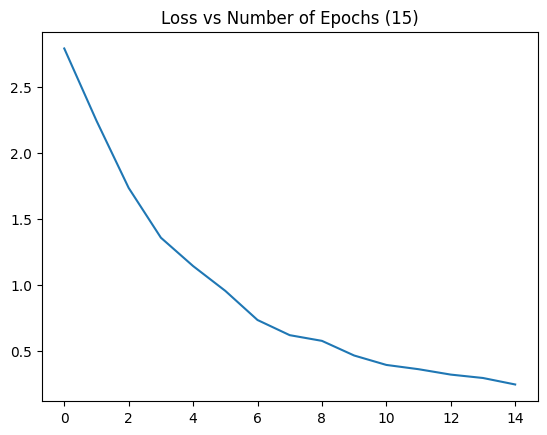

In [73]:
plt.plot(losses)
plt.title("Loss vs Number of Epochs (15)")
plt.show()